In [1]:
#!/usr/bin/env python3
import os
import re
import sys
import collections
import argparse
import tables
import itertools 
import scipy
import matplotlib
import glob
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sp_sparse
import scipy.io as sio
import matplotlib.mlab as mlab

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from multiprocessing import Pool
from collections import defaultdict
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.cluster.hierarchy import dendrogram, linkage

In [19]:
DATA_DIR = '/project/GCRB/Hon_lab/s426305/Analysis/Spade_test/MB231/'
SM_local_df = pd.read_csv(DATA_DIR + 'MB231_SM_local_hit.csv', skip_blank_lines=True)

In [15]:
GWAS_local_df = pd.read_csv(DATA_DIR + 'MB231_GWAS_local_hit.csv', skip_blank_lines=True)

In [20]:
MB231_local_df = GWAS_local_df.append(SM_local_df, ignore_index=True)

In [22]:
MB231_local_df.columns = [
        'idx', 'gene_names', 'chromosome', 'pos', 'strand', 
        'color_idx', 'chr_idx', 'region', 'distance', 'num_cell', 'bin', 
        'pval', 'fc', 'padj-Gaussian', 'fc_by_rand_dist_cpm']

In [23]:
filter_local_df = MB231_local_df[(MB231_local_df['padj-Gaussian'] < -15) & \
                                (MB231_local_df['fc_by_rand_dist_cpm'] < 0.75) & \
                                (MB231_local_df['num_cell'] > 700) & \
                                (MB231_local_df['fc_by_rand_dist_cpm'] != 0)].sort_values(by='padj-Gaussian')

In [24]:
filter_local_df

,idx,gene_names,chromosome,pos,strand,color_idx,chr_idx,region,distance,num_cell,bin,pval,fc,padj-Gaussian,fc_by_rand_dist_cpm
75333,30306,IFITM3,chr11,1809008588,-,0,10,chr11:320278-320778,7259,1375,1400,-136.840317,0.642531,-151638.512739,0.623405
125226,19897,ARHGAP18,chr6,1190908549,-,1,5,chr6:129709987-129710487,238,868,900,-31.007407,0.564345,-116789.680554,0.516007
13915,43827,MT1X,chr16,2457124641,+,1,15,chr16:56682049-56682549,375,1151,1200,-129.303327,0.561235,-69846.011301,0.518831
56299,43812,MT2A,chr16,2457050416,+,1,15,chr16:56607213-56607713,986,1182,1200,-125.312147,0.685124,-38476.308894,0.666498
36981,50784,ETHE1,chr19,2697938532,-,0,18,chr19:43527117-43527617,127,894,900,-10.736120,0.735736,-34876.054793,0.672001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132320,50743,CNFN,chr19,2696801575,-,0,18,chr19:43562738-43563238,1172451,710,700,-2.684857,0.763167,-15.416004,0.718663
84737,902,FAM76A,chr1,27725979,+,0,0,chr1:26530962-26531645,1195017,773,800,-2.949107,0.727419,-15.408563,0.694031
11106,49901,AC005253.2,chr19,2672972848,-,0,18,chr19:18919303-18919803,357743,887,900,-6.645748,0.220910,-15.199730,0.275806
90257,14391,CTSO,chr4,845399427,-,1,3,chr4:156476239-156476810,522322,823,800,-3.382996,0.468139,-15.114460,0.428750


In [25]:
filter_local_df.to_csv('./MB231-filter_local_df.csv')

## Volcano plot
____

In [26]:
DIR = '/project/GCRB/Hon_lab/s426305/Analysis/Spade_test/MB231/Jupyter_plots/'

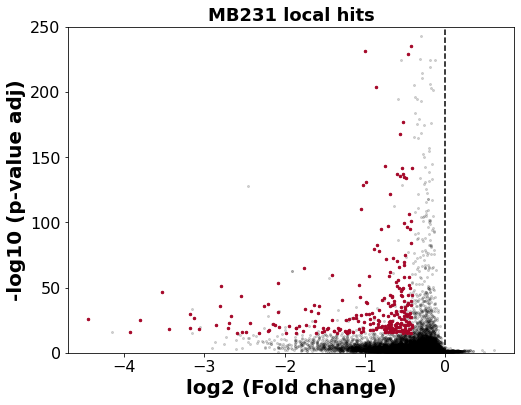

In [28]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(np.log2(MB231_local_df['fc_by_rand_dist_cpm']),
          -MB231_local_df['padj-Gaussian'],
          s=4,
          color='#000000',
          alpha=0.15)

#highlight local hits passing filter 
ax.scatter(np.log2(filter_local_df['fc_by_rand_dist_cpm']),
          -(filter_local_df['padj-Gaussian']),
          s=6,
          color='#A60628')

ax.axvline(0, 
           ls='--', 
           color='#000000')

#label title and axises
ax.set_title('MB231 local hits',
         fontsize=18, fontweight='bold')
#ax.set_xlim([-2,2])
ax.set_ylim([0,250])
ax.set_xlabel('log2 (Fold change)', fontsize=20, fontweight='bold')
plt.xticks(fontsize=16, color='#000000')
ax.set_ylabel('-log10 (p-value adj)', fontsize=20, fontweight='bold')
plt.yticks(fontsize=16, color='#000000')

plt.savefig(DIR + 'MB231_local_hit_volcano-250_hits-v1.tiff')

## Distance histogram plot 
____

In [3]:
local_df_columns = ['idx', 'gene_names', 'chromosome', 'pos', 'strand', 
                    'color_idx', 'chr_idx', 'region', 'distance', 'num_cell', 'bin', 
                    'pval', 'fc', 'padj-Gaussian', 'fc_by_rand_dist_cpm']

In [4]:
local_df = pd.read_csv('./MB231-filter_local_df.csv')[local_df_columns]

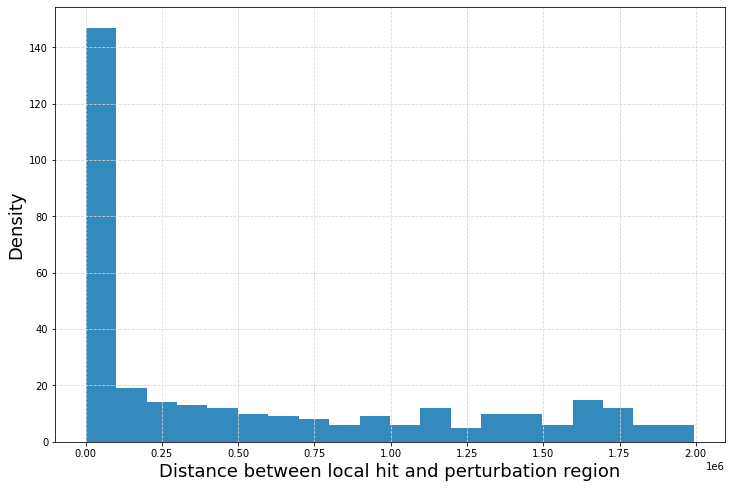

In [12]:
fig, ax = plt.subplots(figsize= (12,8))
ax.grid(ls='--', color='#D8D8D8')

ax.hist(local_df['distance'].values, 
        color='#348ABD',
        bins=20, 
#        alpha=.5
       )

ax.set_ylabel('Density', fontsize=18)
ax.set_xlabel('Distance between local hit and perturbation region', fontsize=18)
plt.savefig('./figures/MB231-local_dist_hist.pdf')